In [1]:
import sys
sys.path.append('/home/jianming/PONet/program/project/FactorVAE')

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import argparse
from Layers import FactorVAE, FeatureExtractor, FactorDecoder, FactorEncoder, FactorPredictor, AlphaLayer, BetaLayer
import os
import random
from dataset import StockDataset
from train_model import train, validate, test

tensor(11.0566, grad_fn=<AddBackward0>) tensor([ 0.0168, -1.0282,  0.1383, -2.1859,  0.0178,  0.0195,  0.1570,  0.4373],
       grad_fn=<AddBackward0>) tensor([0.7016, 0.3057, 0.7647, 0.1065, 0.7021, 0.7030, 0.7747, 0.9355],
       grad_fn=<CopySlices>) tensor([0.0899, 0.0632, 0.0830, 0.1777, 0.0585, 0.1556, 0.1043, 0.0314],
       grad_fn=<ViewBackward0>) tensor([0.7375, 0.6796, 0.7135, 0.7098, 0.6607, 0.6890, 0.6994, 0.7071],
       grad_fn=<ViewBackward0>)


In [22]:
num_epochs = 25
lr = 0.0005
batch_size = 300
num_latent = 20
seq_len = 20
num_factor = 8
hidden_size = 20
seed = 42
save_dir = r'/home/jianming/PONet/program/project/FactorVAE/data/best_models'

In [16]:
# train_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/train_csi300_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
# valid_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/valid_csi300_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
# test_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/test_csi300_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
train_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/train_sp500_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
valid_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/valid_sp500_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")
test_df = pd.read_pickle("/home/jianming/PONet/program/project/FactorVAE/data/test_sp500_QLIB_False_NORM_False_CHAR_False_LEN_20.pkl")

In [17]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [18]:
set_seed(seed)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# create model
feature_extractor = FeatureExtractor(num_latent=num_latent, hidden_size=hidden_size)
factor_encoder = FactorEncoder(num_factors=num_factor, num_portfolio=num_latent, hidden_size=hidden_size)
alpha_layer = AlphaLayer(hidden_size)
beta_layer = BetaLayer(hidden_size, num_factor)
factor_decoder = FactorDecoder(alpha_layer, beta_layer)
factor_predictor = FactorPredictor(batch_size, hidden_size, num_factor)
factorVAE = FactorVAE(feature_extractor, factor_encoder, factor_decoder, factor_predictor)

In [19]:
train_ds = StockDataset(train_df, batch_size, seq_len)
valid_ds = StockDataset(valid_df, batch_size, seq_len)
test_ds = StockDataset(test_df, batch_size, seq_len)

In [20]:
train_dataloader = DataLoader(train_ds, batch_size=300, shuffle=False, num_workers=4)
valid_dataloader = DataLoader(valid_ds, batch_size=300, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_ds, batch_size=300, shuffle=False, num_workers=4)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

factorVAE.to(device)
best_val_loss = 10000.0
optimizer = torch.optim.Adam(factorVAE.parameters(), lr=lr)

In [23]:
run_name = 'modelsp500'
conloss0 = []
kl_loss0 = []
pbar = tqdm(range(num_epochs), desc="Training", position=0,dynamic_ncols = True)
for _ in pbar:
    train_loss, train_conloss, train_kl = train(factorVAE, train_dataloader, optimizer, seq_len)
    val_loss, val_conloss, val_kl = validate(factorVAE, valid_dataloader, seq_len)
    test_loss = np.NaN #test(factorVAE, test_dataloader, args)
    pbar.set_postfix({"Train Loss": train_loss, "Validation Loss": val_loss})
    # print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}") #Test Loss: {test_loss:.4f},
    best_val_loss = val_loss
    conloss0.append([train_conloss,val_conloss])
    kl_loss0.append([train_kl,val_kl])
    #torch.save
    save_root = os.path.join(save_dir, f'{run_name}_{num_factor}.pt')
    torch.save(factorVAE.state_dict(), save_root)

Training:   0%|                                                                                               …

RuntimeError: Caught RuntimeError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 175, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 175, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 149, in default_collate
    return default_collate([torch.as_tensor(b) for b in batch])
  File "/home/jianming/anaconda3/envs/env_qlib3.7/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 140, in default_collate
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable


In [10]:
run_name = 'model22'
conloss = []
kl_loss = []
pbar = tqdm(range(num_epochs), desc="Training", position=0,dynamic_ncols = True)
for _ in pbar:
    train_loss, train_conloss, train_kl = train(factorVAE, train_dataloader, optimizer, seq_len, masked = True)
    val_loss, val_conloss, val_kl = validate(factorVAE, valid_dataloader, seq_len)
    test_loss = np.NaN #test(factorVAE, test_dataloader, args)
    pbar.set_postfix({"Train Loss": train_loss, "Validation Loss": val_loss})
    # print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}") #Test Loss: {test_loss:.4f},
    best_val_loss = val_loss
    conloss.append([train_conloss,val_conloss])
    kl_loss.append([train_kl,val_kl])
    #torch.save
    save_root = os.path.join(save_dir, f'{run_name}_{num_factor}.pt')
    torch.save(factorVAE.state_dict(), save_root)

Training:   0%|                                                                                               …

In [11]:
def list_to_df(loss_list):
    tcl = pd.DataFrame([i[0] for i in loss_list])
    vcl = pd.DataFrame([i[1] for i in loss_list])
    return tcl, vcl

In [12]:
tcl, vcl = list_to_df(conloss0)

In [13]:
tcl.to_csv('tcl_10.csv')
vcl.to_csv('vcl_10.csv')

In [14]:
tcl, vcl = list_to_df(kl_loss0)
tcl.to_csv('tkl_10.csv')
vcl.to_csv('vkl_10.csv')

In [12]:
tcl, vcl = list_to_df(kl_loss)
tcl.to_csv('nntkl_10.csv')
vcl.to_csv('nnvkl_10.csv')

In [13]:
tcl, vcl = list_to_df(conloss)
tcl.to_csv('nntcl_10.csv')
vcl.to_csv('nnvcl_10.csv')

<AxesSubplot:>

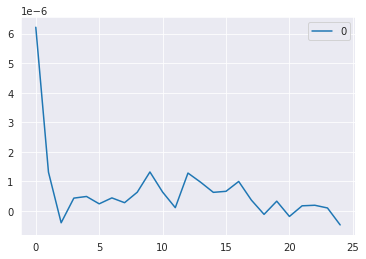

In [14]:
tcl.plot()

<AxesSubplot:>

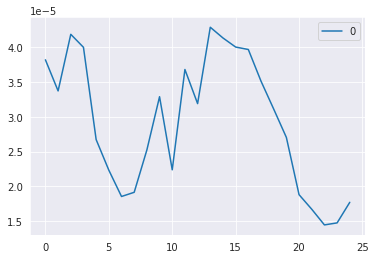

In [15]:
vcl.plot()